In [1]:
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_LAUNCH_BLOCKING=0

env: CUDA_VISIBLE_DEVICES=0
env: CUDA_LAUNCH_BLOCKING=0


In [2]:
from medvqa.utils.files import load_pickle
from medvqa.evaluation.plots import plot_metrics, visualize_image_and_polygons
import numpy as np
import medvqa
import os
from importlib import reload
from medvqa.evaluation.plots import visualize_predicted_bounding_boxes__yolo
from medvqa.utils.constants import VINBIG_BBOX_NAMES

In [123]:
reload(medvqa.evaluation.plots)

<module 'medvqa.evaluation.plots' from '/home/pamessina/medvqa/medvqa/evaluation/plots.py'>

# 1) Phrase Grounding: DenseNet121 + CXRFE + Sigmoid-based attention

In [9]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_feature_extra

In [11]:
tmp1 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240618_175951_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,SigmoidAttention,128,256,256,1)/vindrcxr_metrics.pkl')

In [129]:
tmp = tmp1

In [130]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


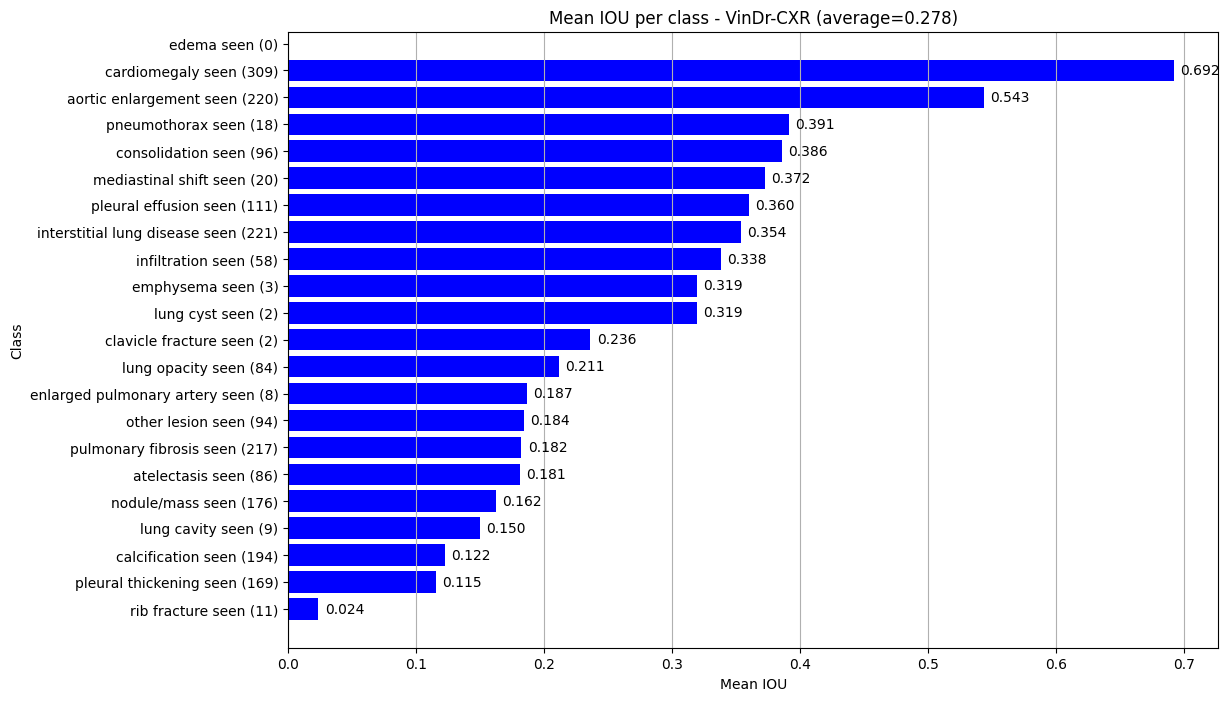

In [131]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [19]:
from medvqa.evaluation.plots import visualize_attention_maps

In [49]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [77]:
# idx = idxs[-200]
idx = idxs[200]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.7070717811584473

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/889347926c284c6c61234b357153d327.jpg

interstitial lung disease seen


In [26]:
from medvqa.datasets.vinbig import load_test_image_id_2_bboxes, visualize_image_with_bounding_boxes
test_image_id_2_bboxes = load_test_image_id_2_bboxes()

Anomalous bboxes found: 0 of 2697


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/889347926c284c6c61234b357153d327.jpg
0: ILD
[[335.2509977817093, 551.816172253801, 788.6113235322391, 1605.0496119547272], [1269.6155715846303, 485.4707587293333, 1753.3842118672085, 1563.5837285019347]]


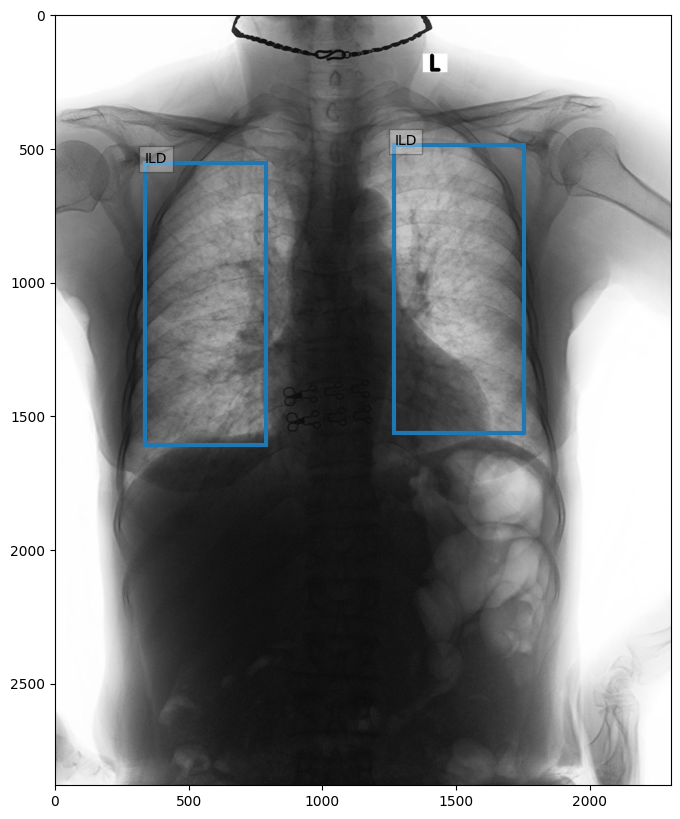

In [78]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

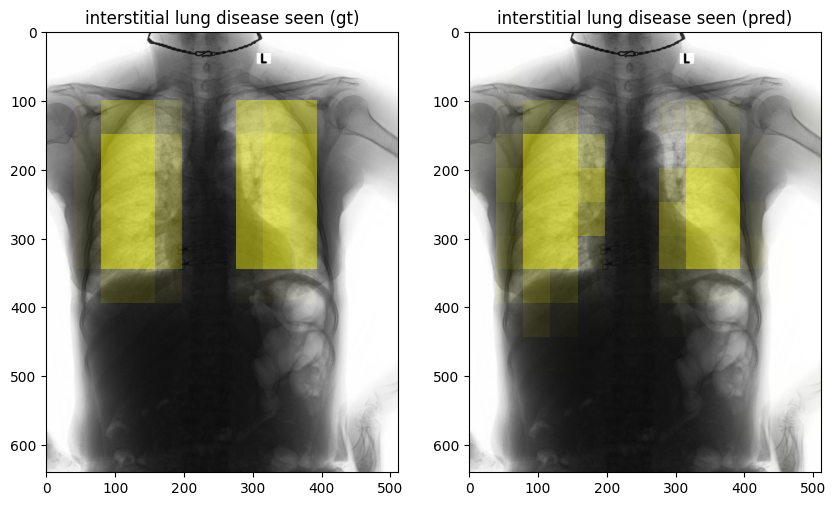

In [79]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

# 2) Phrase Grounding: DenseNet121 + CXRFE + Transformer Encoder

In [80]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240618_093614_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,TransformerEncoder,128,256,4,512,3)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-121
create_densenet121_featu

# 3) Phrase Grounding: DenseNet121 + CXRFE + FiLM-based attention

In [81]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/metadata.json
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPurposeVisualModule()
  Initializing raw_image_encoder: densenet-12

In [82]:
tmp3 = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20240705_131322_mscxr+chst-img-anat+vinbig+chexloc_PhraseGrounder(dn121,FiLM_SigmoidAttention,128,256,256,256,1,256-128)/vindrcxr_metrics.pkl')

In [126]:
tmp = tmp3

In [127]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_masks', 'gt_masks', 'ious', 'segmask_iou', 'prc_auc'])

posx and posy should be finite values


posx and posy should be finite values


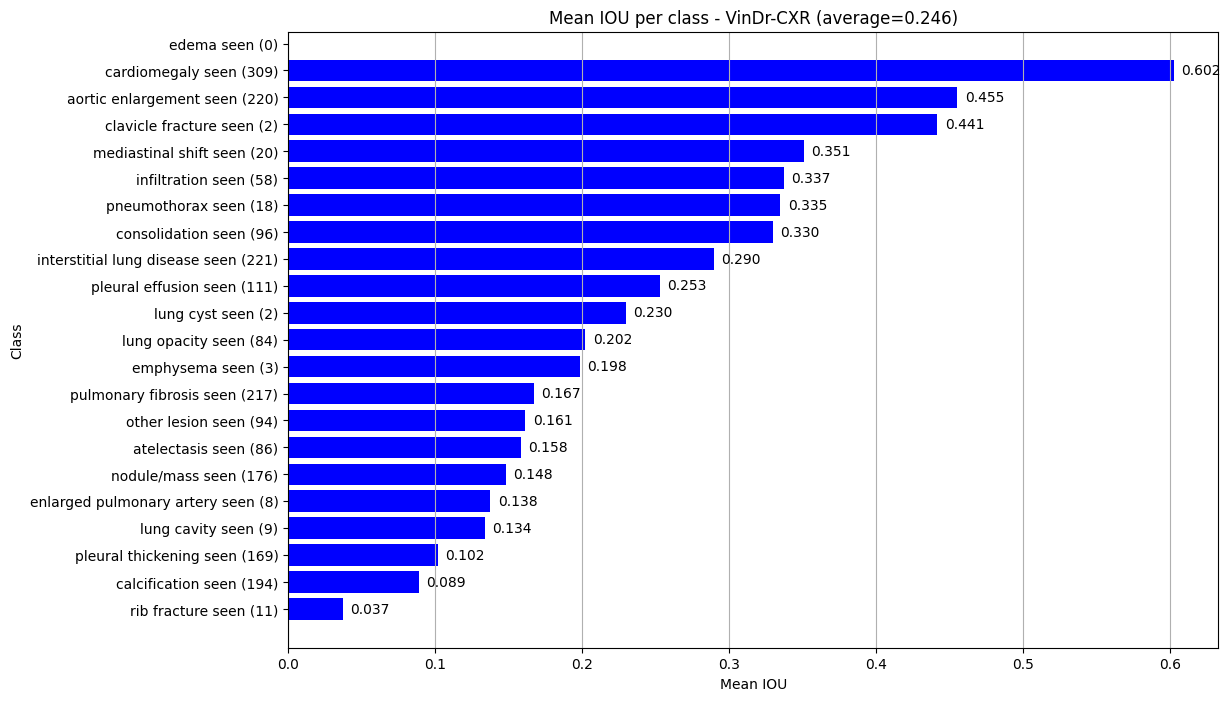

In [128]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [87]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [116]:
# idx = idxs[-200]
idx = idxs[-500]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0.06893625110387802

/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/b856f3db2491d631aa4300206b97ff82.jpg

pulmonary fibrosis seen


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/b856f3db2491d631aa4300206b97ff82.jpg
0: ILD
[[456.8576358404049, 1316.1147173953464, 1046.6127684311336, 1896.35767042816]]
1: Nodule/Mass
[[725.2047387729664, 1460.8034860750136, 1043.8627539631182, 1734.278648365069]]
2: Pleural effusion
[[335.5773464769885, 1630.0166428065406, 689.9060350093217, 1939.1624784387773]]
3: Pleural thickening
[[2085.442266866496, 1979.2380226523337, 2181.980020369589, 2239.889957110689]]
4: Pulmonary fibrosis
[[418.8089176087447, 1194.8344280319302, 789.7839203674289, 1356.541480516485]]


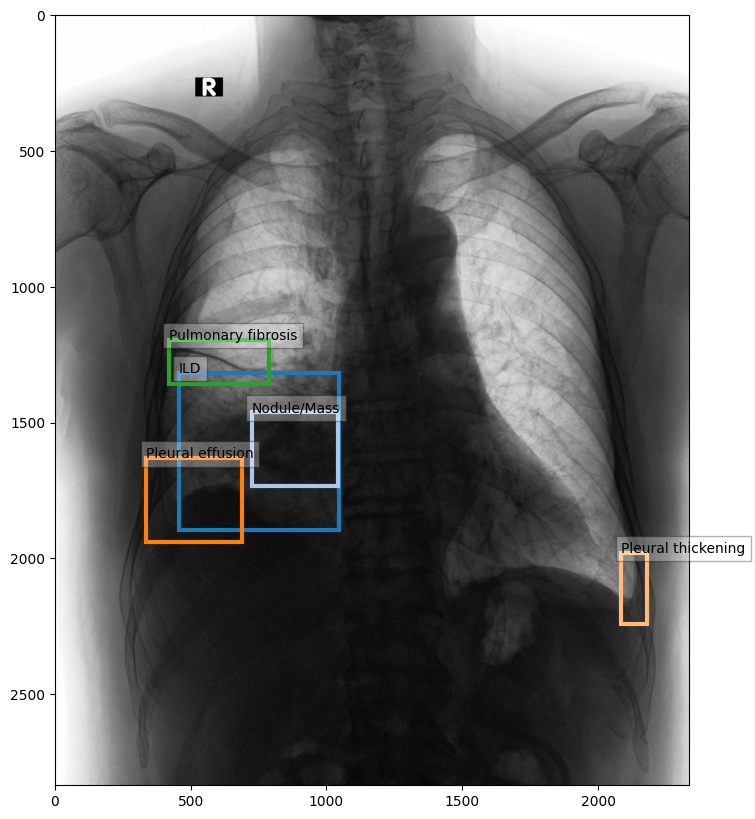

In [117]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

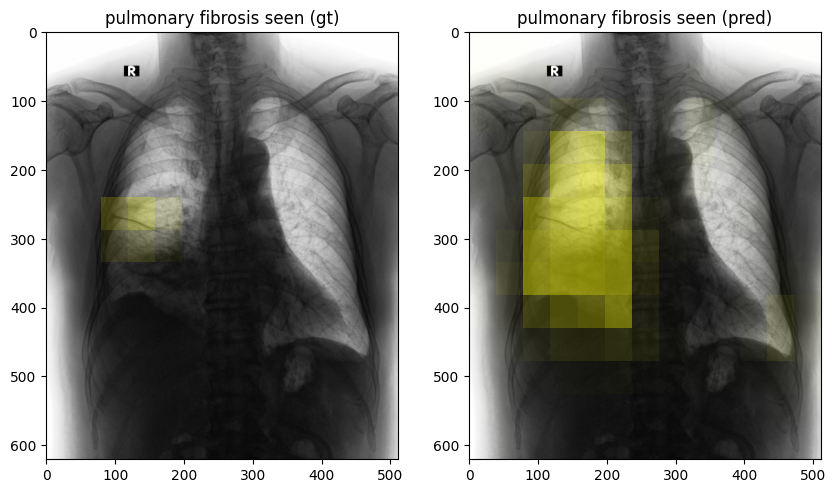

In [118]:
visualize_attention_maps(
    image_path=tmp['image_paths'][idx],
    figsize=(10,10),
    attention_factor=0.5,
    attention_maps=[
        tmp['gt_masks'][idx].reshape(13,13),
        tmp['pred_masks'][idx].reshape(13,13),
    ],
    titles=[
        f"{tmp['phrases'][idx]} (gt)",
        f"{tmp['phrases'][idx]} (pred)",
    ],
)

In [90]:
from medvqa.datasets.vinbig import load_train_image_id_2_bboxes

In [91]:
train_image_id_2_bboxes = load_train_image_id_2_bboxes()

Anomalous bboxes found: 0 of 37367


image_path: /mnt/workspace/vinbig-cxr/dataset-jpg/images/0007d316f756b3fa0baea2ff514ce945.jpg
0: Aortic enlargement
[[1275.2900390625, 1039.9000244141, 1498.7099609375, 1241.6199951172], [1235.9799804688, 1021.6400146484, 1482.9000244141, 1281.9799804688]]
1: Cardiomegaly
[[902.03997802734, 1827.7399902344, 1829.6700439453, 2037.0200195312]]
2: ILD
[[1847.3100585938, 1409.9899902344, 2093.1201171875, 2096.5500488281], [535.40399169922, 1748.9799804688, 932.21997070312, 2013.0600585938]]
3: Pleural thickening
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [621.36499023438, 673.40600585938, 1025.8599853516, 851.7340087890599], [790.0479736328099, 634.90301513672, 1047.8399658203, 725.0390014648401]]
4: Pulmonary fibrosis
[[818.666015625, 677.09802246094, 987.66998291016, 939.34497070312], [804.0040283203099, 716.57000732422, 857.5239868164099, 920.35797119141], [1392.7199707031, 702.15997314453, 1518.2900390625, 790.67401123047]]


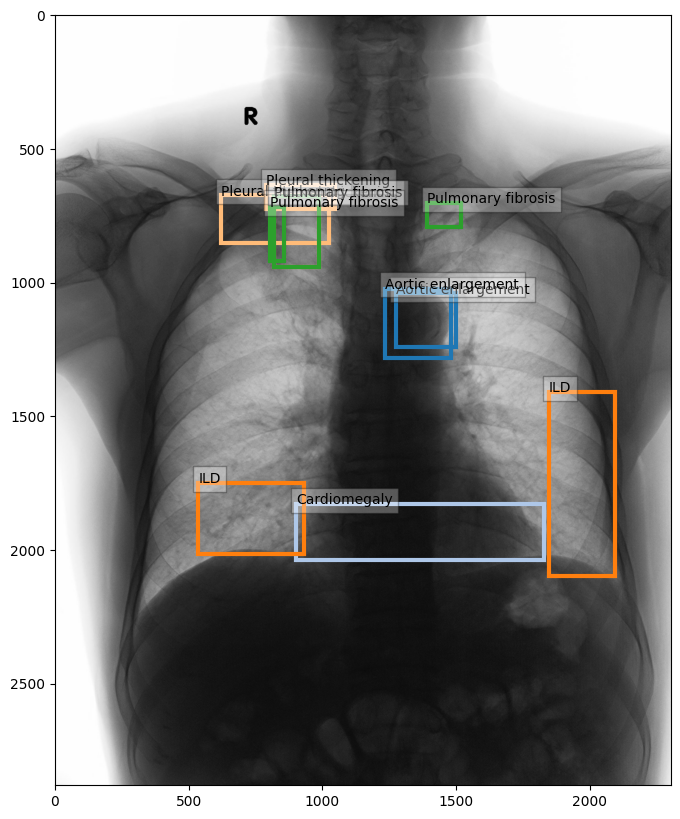

In [11]:
key = os.path.basename('/mnt/workspace/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/0007d316f756b3fa0baea2ff514ce945.jpg')[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

# 4) Phrase Grounding: DN121+CXRFE+FiLM+bbox (VinDR-CXR)

In [75]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPu

In [314]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig \
--use_amp

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: True
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241128_153116_vinbig_PhraseGrounde

conf_th=0.2, iou_th=0.3, mAP=0.1589726362394991 (time_input_processing=1.8959667682647705, time_map=3.063363552093506)
conf_th=0.2, iou_th=0.4, mAP=0.15851107845651716 (time_input_processing=1.9004037380218506, time_map=3.484243392944336)
conf_th=0.2, iou_th=0.5, mAP=0.1540548961216925 (time_input_processing=2.158745050430298, time_map=4.115062475204468)
conf_th=0.3, iou_th=0.02, mAP=0.1552950837733238 (time_input_processing=1.8517069816589355, time_map=2.000192880630493)
conf_th=0.3, iou_th=0.05, mAP=0.15525899889389516 (time_input_processing=1.8519091606140137, time_map=2.050588607788086)
conf_th=0.3, iou_th=0.1, mAP=0.15621570737880364 (time_input_processing=1.8479290008544922, time_map=2.151925802230835)
conf_th=0.3, iou_th=0.2, mAP=0.15481551566131488 (time_input_processing=2.108630895614624, time_map=2.4268438816070557)
conf_th=0.3, iou_th=0.3, mAP=0.15888257568099867 (time_input_processing=1.8540863990783691, time_map=2.760392427444458)
conf_th=0.3, iou_th=0.4, mAP=0.15845454414

In [109]:
tmp = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

In [110]:
tmp.keys()

dict_keys(['image_paths', 'phrases', 'pred_bboxes', 'gt_bboxes', 'ious', 'bbox_iou', 'prc_auc'])

In [141]:
from medvqa.utils.files import get_cached_pickle_file
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

def iou_macro_average(metrics_path):
    tmp = get_cached_pickle_file(metrics_path)
    phrase2idxs = { x:[] for x in vinbig_phrases }
    for idx, phrase in enumerate(tmp['phrases']):
        phrase2idxs[phrase].append(idx)
    
    count = 0
    acc_iou = 0
    for idxs in phrase2idxs.values():
        if len(idxs) > 0:
            acc_iou += np.mean([tmp['ious'][idx] for idx in idxs])
            count += 1
    assert count > 0
    return acc_iou / count

In [142]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16353653144077654

/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pamessina/venv2/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values


posx and posy should be finite values


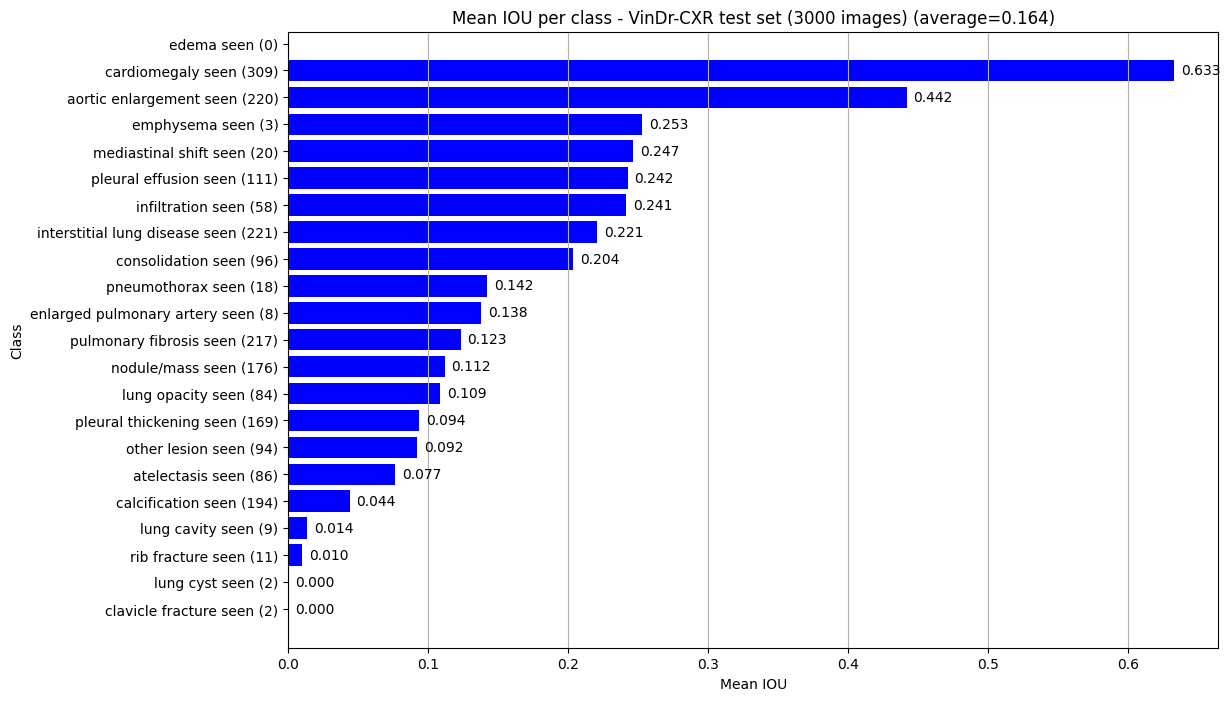

In [117]:


vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [68]:
reload(medvqa.datasets.vinbig)

<module 'medvqa.datasets.vinbig' from '/home/pamessina/medvqa/medvqa/datasets/vinbig/__init__.py'>

In [69]:
from medvqa.datasets.vinbig import compute_label_frequencies

In [70]:
label_frequencies = compute_label_frequencies()

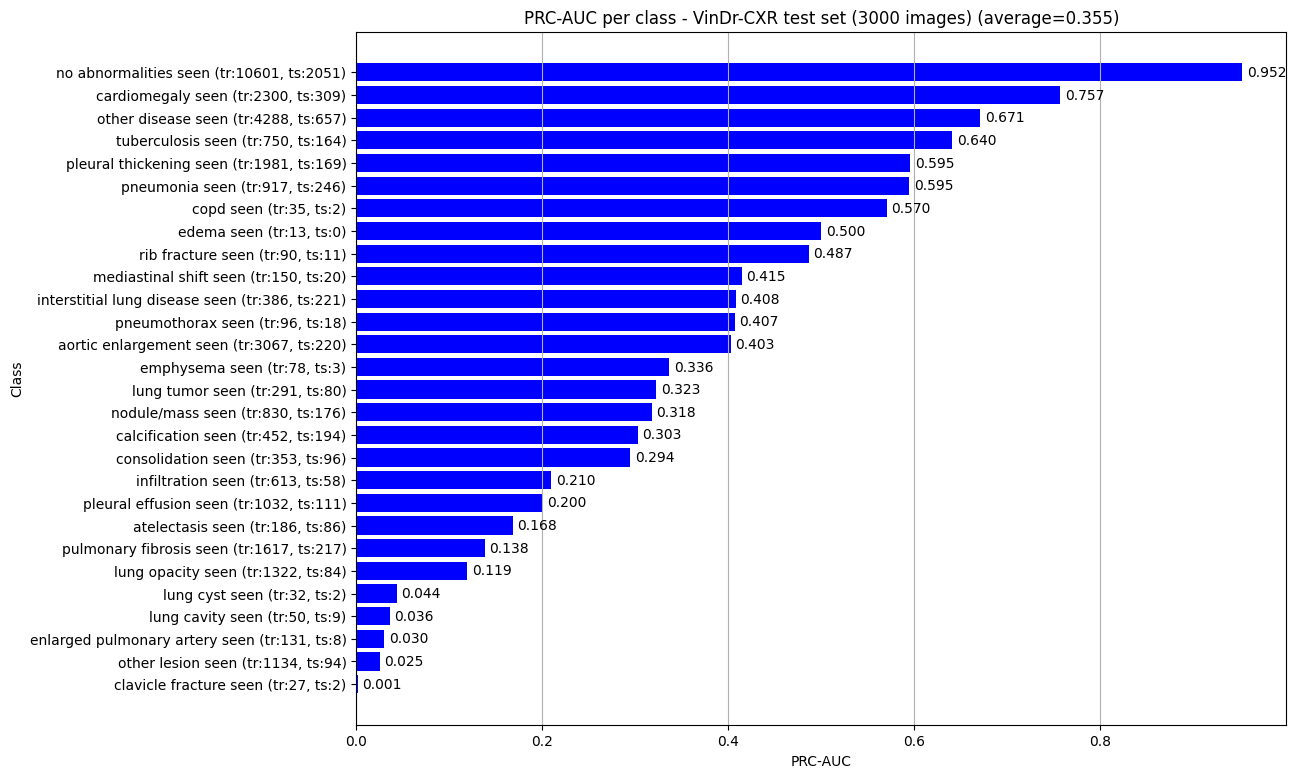

In [118]:
from medvqa.utils.constants import VINBIG_LABELS, VINBIG_LABEL2PHRASE

plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} (tr:{label_frequencies["train"][x]}, ts:{label_frequencies["test"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR test set (3000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 9),
    append_average_to_title=True,
)

In [119]:
idxs = np.argsort(tmp['ious'])[::-1]
len(idxs)

2108

In [133]:
idx = idxs[-10]
print(tmp['ious'][idx])
print()
print(tmp['image_paths'][idx])
print()
print(tmp['phrases'][idx])

0

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/c28e30456f3d1b1dda8a22f958b7aa96.jpg

consolidation seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/c28e30456f3d1b1dda8a22f958b7aa96.jpg
0: Consolidation
[[1234.2674134950737, 1197.0789112898806, 1561.2234809904303, 1504.8022689325694]]


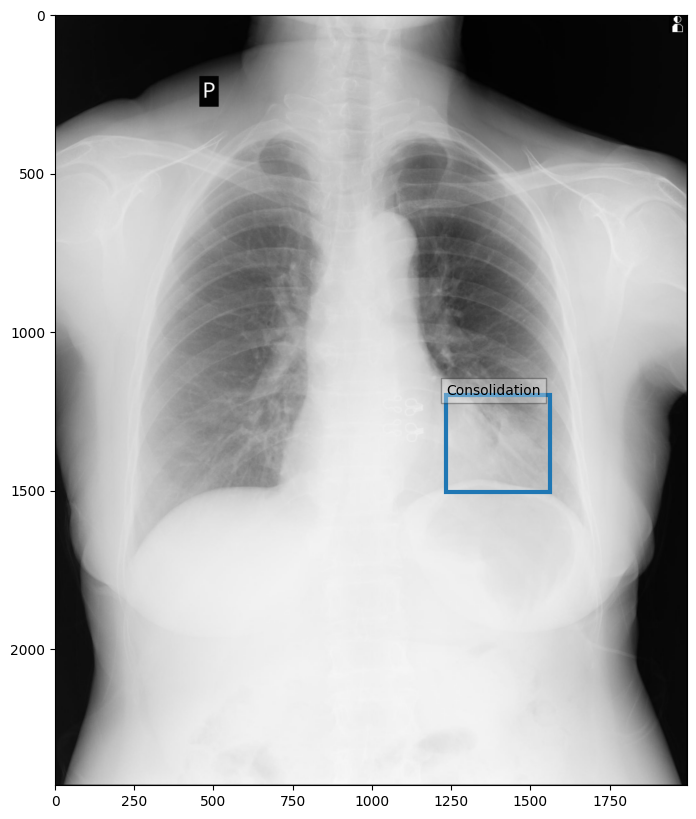

In [134]:
key = os.path.basename(tmp['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, test_image_id_2_bboxes[key], verbose=True)

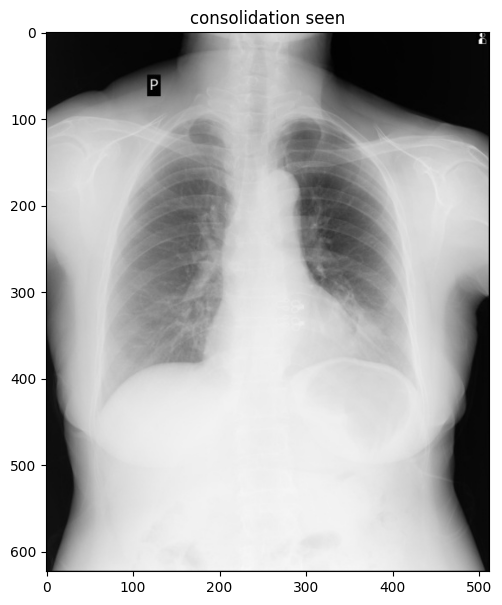

In [135]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp['image_paths'][idx],
    phrases=[tmp['phrases'][idx]],
    bboxes=[tmp['pred_bboxes'][idx]] if tmp['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

In [74]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig \
--vinbig_use_training_indices_for_validation

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of PhraseGrounder ...
MultiPur

In [76]:
tmp2 = load_pickle("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241021_151424_vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression).pkl")

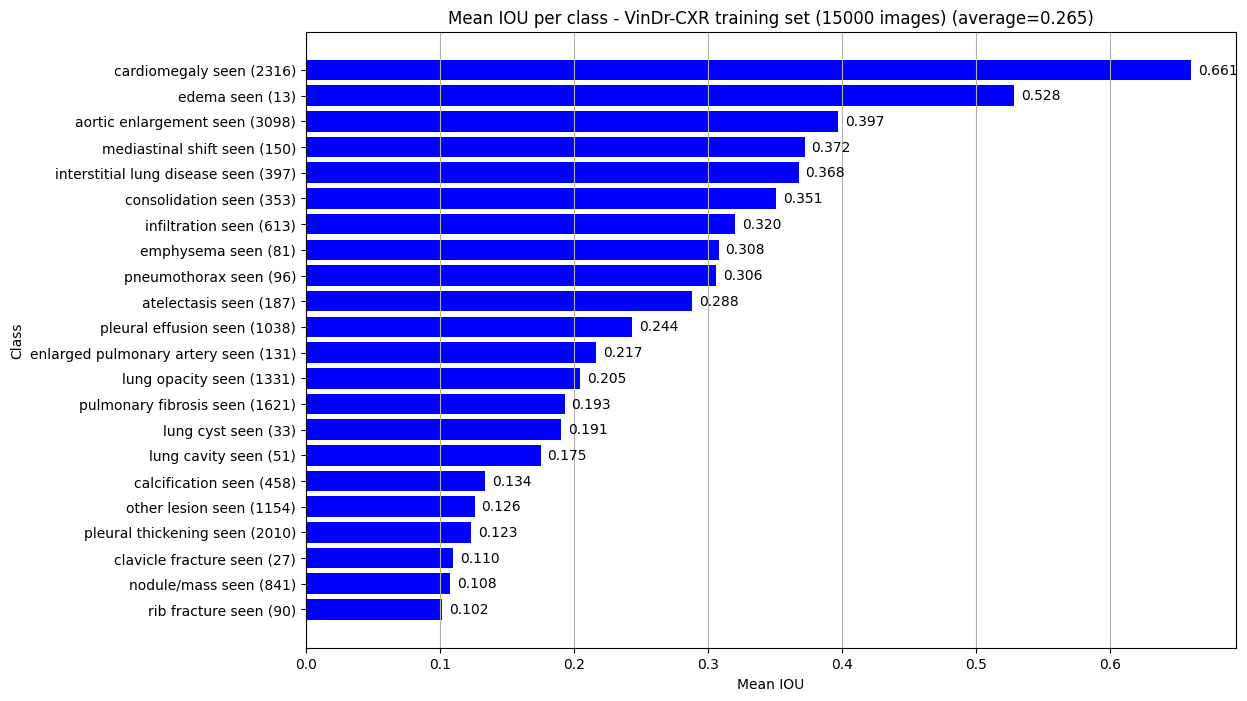

In [81]:
from medvqa.utils.constants import VINBIG_BBOX_NAMES, VINBIG_LABEL2PHRASE

vinbig_phrases = [VINBIG_LABEL2PHRASE[x] for x in VINBIG_BBOX_NAMES]
phrase2idxs = { x:[] for x in vinbig_phrases }
for idx, phrase in enumerate(tmp2['phrases']):
    phrase2idxs[phrase].append(idx)

phrase2mean_iou = {}
for phrase, idxs in phrase2idxs.items():
    phrase2mean_iou[phrase] = np.mean([tmp2['ious'][idx] for idx in idxs])

plot_metrics(
    metric_names=[f'{name} ({len(phrase2idxs[name])})' for name in vinbig_phrases],
    metric_values=[phrase2mean_iou[phrase] for phrase in vinbig_phrases],
    title='Mean IOU per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='Mean IOU',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

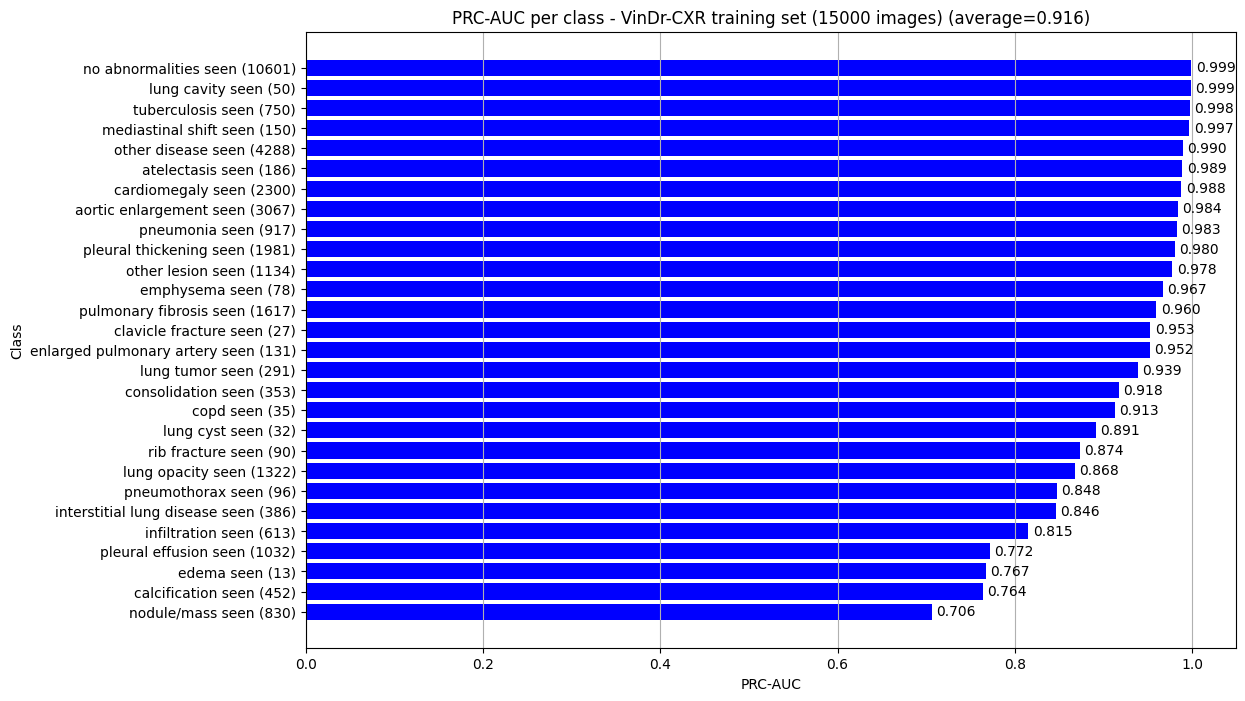

In [83]:
plot_metrics(
    metric_names=[f'{VINBIG_LABEL2PHRASE[x]} ({label_frequencies["train"][x]})' for x in VINBIG_LABELS],
    metric_values=tmp2['prc_auc']['per_class'],
    title='PRC-AUC per class - VinDr-CXR training set (15000 images)',
    ylabel='Class',
    xlabel='PRC-AUC',
    horizontal=True,
    sort_metrics=True,
    show_metrics_above_bars=True,
    draw_grid=True,
    figsize=(12, 8),
    append_average_to_title=True,
)

In [86]:
idxs = np.argsort(tmp2['ious'])[::-1]
len(idxs)

16089

In [104]:
idx = idxs[-1000]
print(tmp2['ious'][idx])
print()
print(tmp2['image_paths'][idx])
print()
print(tmp2['phrases'][idx])

0.01016150708654602

/mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images-512x512(keep_aspect_ratio)/afb41a2217d37b54f0427fc1c69336be.jpg

pulmonary fibrosis seen


image_path: /mnt/data/chest_related_backup/vinbig-cxr/dataset-jpg/images/afb41a2217d37b54f0427fc1c69336be.jpg
0: Consolidation
[[702.4110107421901, 1225.1600341797, 1186.9799804688, 1614.6899414062]]
1: Infiltration
[[645.81799316406, 1281.3299560547, 1115.6899414062, 1657.7900390625], [670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
2: Lung Opacity
[[670.5830078125, 1128.7399902344, 1167.3100585938, 1650.1600341797]]
3: Pleural thickening
[[904.57000732422, 345.76998901367006, 1203.4699707031, 500.55499267578006]]
4: Pulmonary fibrosis
[[781.3980102539099, 814.30200195312, 852.4520263671901, 880.28100585938]]


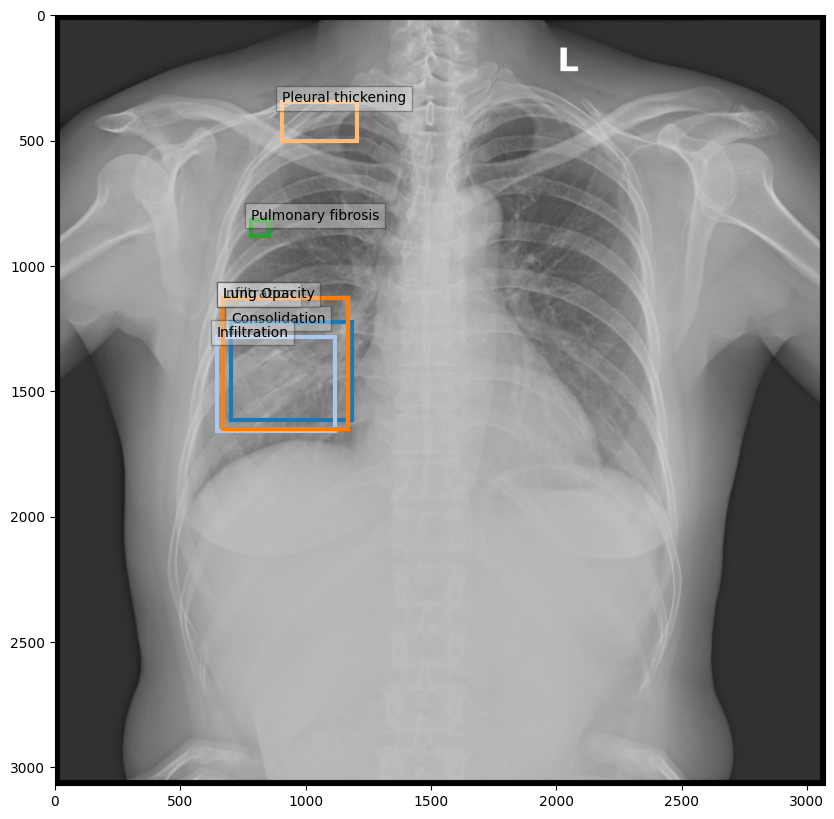

In [105]:
key = os.path.basename(tmp2['image_paths'][idx])[:-4]
visualize_image_with_bounding_boxes(key, train_image_id_2_bboxes[key], verbose=True)

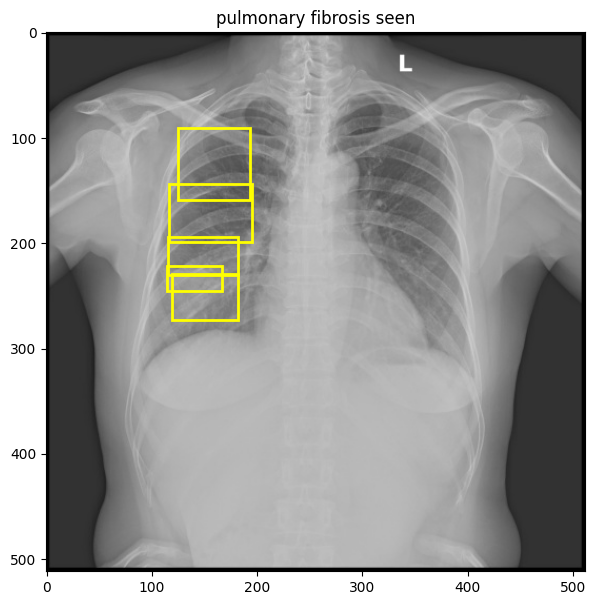

In [106]:
from medvqa.evaluation.plots import visualize_visual_grounding_as_bboxes
visualize_visual_grounding_as_bboxes(
    image_path=tmp2['image_paths'][idx],
    phrases=[tmp2['phrases'][idx]],
    bboxes=[tmp2['pred_bboxes'][idx]] if tmp2['pred_bboxes'][idx] is not None else [[]],
    figsize=(7, 7),
    max_cols=1,
)

# 5) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR

In [107]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance o

In [143]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14017660799139942

In [311]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-img-anat+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241018_062313_chst-

conf_th=0.2, iou_th=0.2, mAP=0.10186465944381569 (time_input_processing=2.0248382091522217, time_map=3.0251171588897705)
conf_th=0.2, iou_th=0.3, mAP=0.10082598605000724 (time_input_processing=2.2953073978424072, time_map=3.6223721504211426)
conf_th=0.2, iou_th=0.4, mAP=0.10095420678776504 (time_input_processing=1.996204137802124, time_map=4.403188943862915)
conf_th=0.2, iou_th=0.5, mAP=0.10026306132685069 (time_input_processing=2.000032901763916, time_map=5.68297815322876)
conf_th=0.3, iou_th=0.02, mAP=0.10402990990329891 (time_input_processing=1.9782485961914062, time_map=2.2034034729003906)
conf_th=0.3, iou_th=0.05, mAP=0.10292990271491692 (time_input_processing=1.9743216037750244, time_map=2.554919719696045)
conf_th=0.3, iou_th=0.1, mAP=0.10264670320115897 (time_input_processing=1.9792866706848145, time_map=2.438201665878296)
conf_th=0.3, iou_th=0.2, mAP=0.10095572911671041 (time_input_processing=1.9816555976867676, time_map=3.1297547817230225)
conf_th=0.3, iou_th=0.3, mAP=0.100807

# 6) Phrase Grounding: DN121+CXRFE+FiLM+bbox; Chest ImaGenome + VinDR-CXR + MIMIC-CXR (facts + GPT-4 labels)

In [136]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
--------------------------------------------------
1) device = cuda
---------------------

In [144]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.1521956186451413

In [310]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/" \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241022_220201_mim-facts+chst-img-anat+cxrlt2024(GPT4)+vinbig_PhraseGrounder(dn121,FiLM_SigmoidAttention_ObjectDetection,128,256,256,256-128)/
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grou

conf_th=0.2, iou_th=0.05, mAP=0.11729295486746626 (time_input_processing=2.2565577030181885, time_map=2.727806329727173)
conf_th=0.2, iou_th=0.1, mAP=0.11633540051578728 (time_input_processing=1.9973723888397217, time_map=2.9368038177490234)
conf_th=0.2, iou_th=0.2, mAP=0.1165064511903442 (time_input_processing=1.9978480339050293, time_map=3.6885738372802734)
conf_th=0.2, iou_th=0.3, mAP=0.11885897020856935 (time_input_processing=2.0056300163269043, time_map=4.03694486618042)
conf_th=0.2, iou_th=0.4, mAP=0.11828319705039471 (time_input_processing=2.011373996734619, time_map=5.0844151973724365)
conf_th=0.2, iou_th=0.5, mAP=0.11993134284377654 (time_input_processing=2.013296127319336, time_map=5.771182060241699)
conf_th=0.3, iou_th=0.02, mAP=0.11857200594378878 (time_input_processing=1.9893605709075928, time_map=2.1964449882507324)
conf_th=0.3, iou_th=0.05, mAP=0.11694452796931384 (time_input_processing=2.0064337253570557, time_map=1.965209722518921)
conf_th=0.3, iou_th=0.1, mAP=0.116007

# 7) DN121+CXRFE+Global Pooling+FiLM+MLP; VinDR-CXR

In [315]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)" \
--max_images_per_batch 100 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)
   max_images_per_batch: 100
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 0
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_183113_vinbig_PhraseGrounder(dn121,GlobalPoolingFiLMMLP,128,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 8) DN121+CXRFE+Global Pooling+Concat+MLP; VinDR-CXR

In [316]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241026_175236_vinbig_PhraseGrounder(dn121,GlobalPoolingConcatMLP,128,256-128)/metadata.json
do_visual_grounding_with_b

# 9) DN121+CXRFE+FiLM Attention Pooling+MLP; VinDR-CXR

In [317]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005233_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_

# 10) DN121+CXRFE+Transformer (classif. only); VinDR-CXR

In [318]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241027_005334_vinbig_PhraseGrounder(dn121,TransformerEncoder_NoGrounding,128,256,4,256,2)/metadata.json
do

# 11) DN121+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [153]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance

In [154]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.11413830329169078

In [300]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_153038_vinbig_PhraseGrounder(dn121

conf_th=0.2, iou_th=0.5, mAP=0.13563813367743507 (time_input_processing=1.627943992614746, time_map=3.676935911178589)
conf_th=0.3, iou_th=0.02, mAP=0.13381928159178055 (time_input_processing=1.5815846920013428, time_map=1.7964768409729004)
conf_th=0.3, iou_th=0.05, mAP=0.13462077119040838 (time_input_processing=1.5820250511169434, time_map=1.8527426719665527)
conf_th=0.3, iou_th=0.1, mAP=0.13446295206118516 (time_input_processing=1.583618402481079, time_map=1.9590041637420654)
conf_th=0.3, iou_th=0.2, mAP=0.13435236082749438 (time_input_processing=1.5865767002105713, time_map=2.478414297103882)
conf_th=0.3, iou_th=0.3, mAP=0.13434030622361456 (time_input_processing=1.5894546508789062, time_map=2.5690228939056396)
conf_th=0.3, iou_th=0.4, mAP=0.13561769240547508 (time_input_processing=1.5823071002960205, time_map=2.916461706161499)
conf_th=0.3, iou_th=0.5, mAP=0.1352255173634387 (time_input_processing=1.593003273010254, time_map=3.3357887268066406)
conf_th=0.4, iou_th=0.02, mAP=0.13269

# 12) aehrc-cxrmate-rrg24-uniformer+CXRFE+Transformer+BBox+Classif; VinDR-CXR

In [155]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
-----------------------

In [156]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.14304222217816195

In [298]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,TransformerEncoder_BBoxRegression,128,256,4,256,2)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241029_092356_vin

conf_th=0.2, iou_th=0.5, mAP=0.19441760859015955 (time_input_processing=1.4390716552734375, time_map=3.0499114990234375)
conf_th=0.3, iou_th=0.02, mAP=0.189575620863787 (time_input_processing=1.408747673034668, time_map=1.507448434829712)
conf_th=0.3, iou_th=0.05, mAP=0.19166873431996712 (time_input_processing=1.4025530815124512, time_map=1.551276445388794)
conf_th=0.3, iou_th=0.1, mAP=0.19370217158897038 (time_input_processing=1.4056627750396729, time_map=1.6593258380889893)
conf_th=0.3, iou_th=0.2, mAP=0.19292409185586742 (time_input_processing=1.4069797992706299, time_map=1.7942376136779785)
conf_th=0.3, iou_th=0.3, mAP=0.19622181776683084 (time_input_processing=1.4070916175842285, time_map=1.9996514320373535)
conf_th=0.3, iou_th=0.4, mAP=0.1946834887641203 (time_input_processing=1.4036262035369873, time_map=2.257585287094116)
conf_th=0.3, iou_th=0.5, mAP=0.19420019698810675 (time_input_processing=1.4079680442810059, time_map=2.5842959880828857)
conf_th=0.4, iou_th=0.02, mAP=0.18848

# 13) DN121+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [157]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
--------------------------------------------------
2) Creating instance of 

In [158]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.16770028737995715

In [299]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241028_164357_vinbig_PhraseGrounder(dn121,A

conf_th=0.2, iou_th=0.5, mAP=0.17510149494242 (time_input_processing=1.803011178970337, time_map=3.519442081451416)
conf_th=0.3, iou_th=0.02, mAP=0.17865229561728782 (time_input_processing=1.726893424987793, time_map=1.654174566268921)
conf_th=0.3, iou_th=0.05, mAP=0.18000644078764874 (time_input_processing=1.7593894004821777, time_map=1.71073317527771)
conf_th=0.3, iou_th=0.1, mAP=0.1799449062414996 (time_input_processing=1.7443161010742188, time_map=1.7830615043640137)
conf_th=0.3, iou_th=0.2, mAP=0.1766691516459239 (time_input_processing=1.72940993309021, time_map=1.978147029876709)
conf_th=0.3, iou_th=0.3, mAP=0.1780763734809259 (time_input_processing=1.738105058670044, time_map=2.23178768157959)
conf_th=0.3, iou_th=0.4, mAP=0.18082619232939232 (time_input_processing=2.0069258213043213, time_map=2.560245990753174)
conf_th=0.3, iou_th=0.5, mAP=0.17608449356081243 (time_input_processing=1.7558352947235107, time_map=2.972668170928955)
conf_th=0.4, iou_th=0.02, mAP=0.17767252092014557 

# 14) aehrc-cxrmate-rrg24-uniformer+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [159]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
---------------------------

In [67]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: False
   candidate_iou_thresholds: None
   candidate_conf_thresholds: None
   map_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do

In [237]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.05 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,Adaptive

iou_th=0.1, conf_th=0.3, mAP=0.21285335768481578 (time_input_processing=1.4212632179260254, time_map=1.5613293647766113)
iou_th=0.2, conf_th=0.3, mAP=0.21481562156494832 (time_input_processing=1.4012439250946045, time_map=1.7112152576446533)
iou_th=0.3, conf_th=0.3, mAP=0.2123034239882527 (time_input_processing=1.6750328540802002, time_map=1.8930144309997559)
iou_th=0.4, conf_th=0.3, mAP=0.2114619054365659 (time_input_processing=1.41766357421875, time_map=2.122950315475464)
iou_th=0.5, conf_th=0.3, mAP=0.2059878034520273 (time_input_processing=1.4228854179382324, time_map=2.4600119590759277)
iou_th=0.1, conf_th=0.4, mAP=0.2128858288036254 (time_input_processing=1.3853273391723633, time_map=1.4894113540649414)
iou_th=0.2, conf_th=0.4, mAP=0.21497524083527503 (time_input_processing=1.3860771656036377, time_map=1.6168768405914307)
iou_th=0.3, conf_th=0.4, mAP=0.2126868386322812 (time_input_processing=1.3713436126708984, time_map=1.7768633365631104)
iou_th=0.4, conf_th=0.4, mAP=0.211876901

In [275]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 200 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 200
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_125216_vinbi

iou_th=0.5, conf_th=0.2, mAP=0.22681358303640178 (time_input_processing=1.4704170227050781, time_map=2.8502895832061768)
iou_th=0.02, conf_th=0.3, mAP=0.22987994495274303 (time_input_processing=1.41888427734375, time_map=1.5441787242889404)
iou_th=0.05, conf_th=0.3, mAP=0.2289466736859538 (time_input_processing=1.419753074645996, time_map=1.5800085067749023)
iou_th=0.1, conf_th=0.3, mAP=0.229847932065386 (time_input_processing=1.4125938415527344, time_map=1.6474854946136475)
iou_th=0.2, conf_th=0.3, mAP=0.2316389208691976 (time_input_processing=1.4143052101135254, time_map=1.8003439903259277)
iou_th=0.3, conf_th=0.3, mAP=0.227953278183278 (time_input_processing=1.4149465560913086, time_map=2.2675180435180664)
iou_th=0.4, conf_th=0.3, mAP=0.2292200226595453 (time_input_processing=1.4164955615997314, time_map=2.2465481758117676)
iou_th=0.5, conf_th=0.3, mAP=0.2257527318926732 (time_input_processing=1.416682243347168, time_map=2.573362350463867)
iou_th=0.02, conf_th=0.4, mAP=0.22863603813

In [3]:
tmp = load_pickle('/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_125216_vinbig_PhraseGrounder(aehrc-cxrmate-rrg24-uniformer,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000,opt_thr(0.20,0.20,50),use_classifier_confs).pkl')

In [4]:
tmp.keys()

dict_keys(['image_paths', 'pred_boxes_list', 'pred_classes_list', 'pred_confs_list', 'classifier_confs', 'gt_bboxes', 'class_ious', 'sample_ious', 'micro_iou', 'macro_iou', 'map_iou_thresholds', 'map_per_class', 'prc_auc', 'best_iou_threshold', 'best_conf_threshold', 'max_det'])

In [5]:
idxs = np.argsort(tmp['sample_ious'])[::-1]

0.09725503


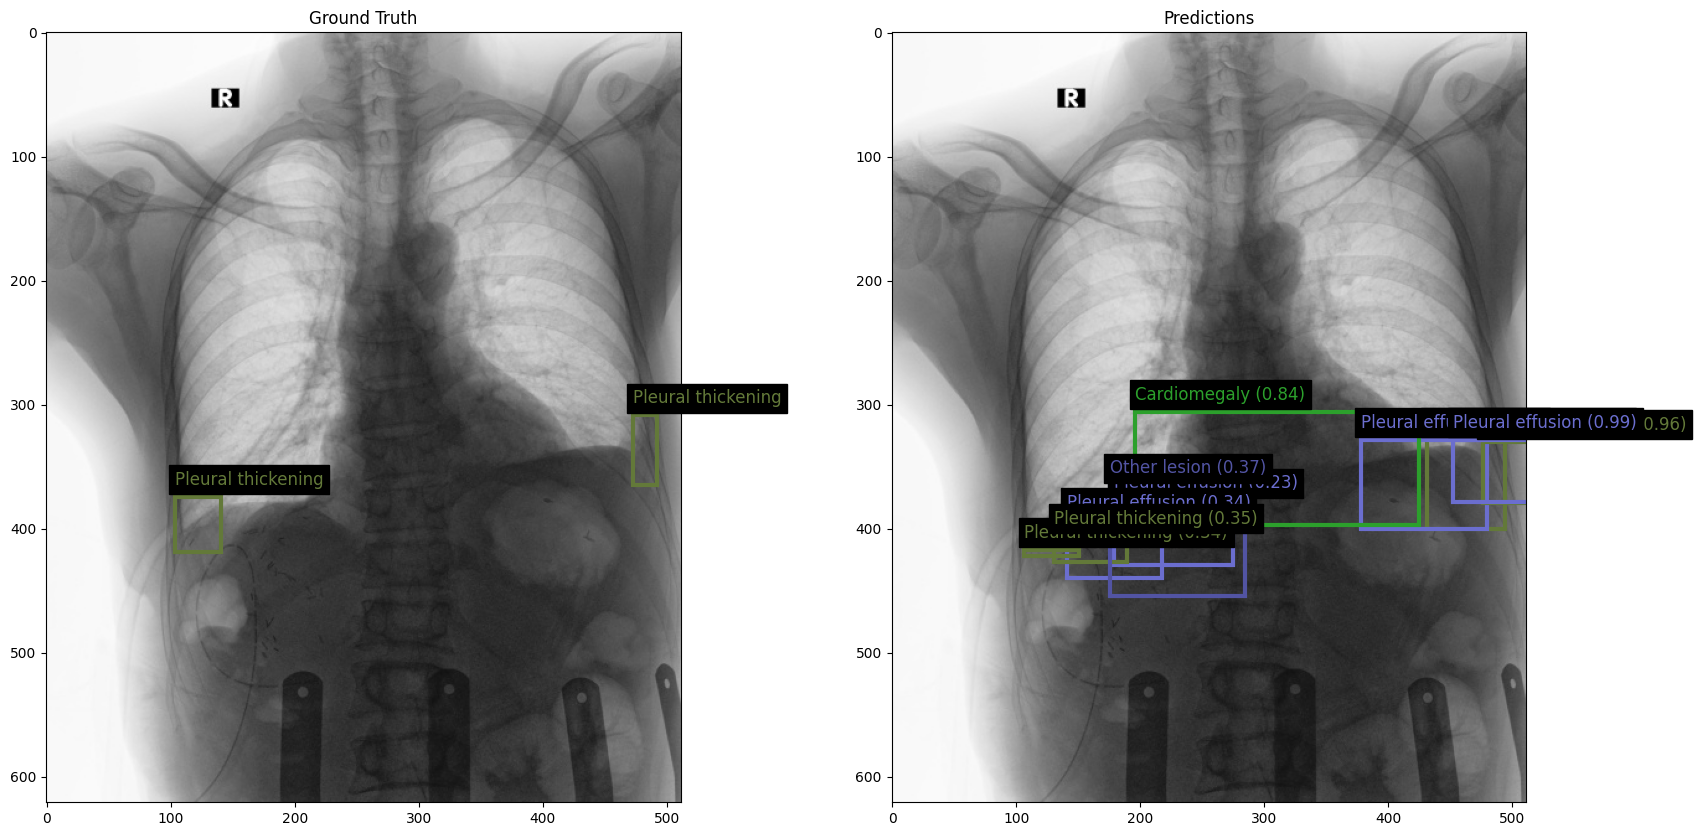

In [8]:
i = 800
i = idxs[i]
print(tmp['sample_ious'][i])
visualize_predicted_bounding_boxes__yolo(
    image_path=tmp['image_paths'][i],
    pred_coords=tmp['pred_boxes_list'][i],
    pred_classes=tmp['pred_classes_list'][i],
    pred_confs=tmp['pred_confs_list'][i],
    gt_bbox_coords=tmp['gt_bboxes'][i],
    class_names=VINBIG_BBOX_NAMES,
    figsize=(20, 10),
    format='xyxy',
)

# 15) microsoft-rad-dino-maira-2+CXRFE+FiLM Attention Pooling+BBox+Classif; VinDR-CXR

In [163]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/metadata.json
do_visual_grounding_with_bbox_regression = True
do_visual_grounding_with_segmentation = False
--------------------------------------------------
1) device = cuda
----------------------------------

In [164]:
iou_macro_average("/mnt/data/pamessina/workspaces/medvqa-workspace/results/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)/vindrcxr_metrics(bbox_regression,3000).pkl")

0.17359745572300675

In [296]:
!python ../eval_phrase_grounding.py \
--checkpoint_folder_path "/mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)" \
--num_workers 3 \
--max_images_per_batch 50 \
--max_phrases_per_batch 2000 \
--max_phrases_per_image 30 \
--optimize_thresholds \
--candidate_iou_thresholds 0.02 0.05 0.1 0.2 0.3 0.4 0.5 \
--candidate_conf_thresholds 0.1 0.2 0.3 0.4 0.5 0.6 0.7 \
--use_classifier_confs_for_map \
--eval_vinbig

script's arguments:
   checkpoint_folder_path: /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_PhraseGrounder(microsoft-rad-dino-maira-2,AdaptiveFiLM_MLP_BBoxRegression,128,256,256-128)
   max_images_per_batch: 50
   max_phrases_per_batch: 2000
   max_phrases_per_image: 30
   num_workers: 3
   device: GPU
   mscxr_phrase2embedding_filepath: None
   eval_chest_imagenome_gold: False
   eval_mscxr: False
   eval_chexlocalize: False
   eval_vinbig: True
   vinbig_use_training_indices_for_validation: False
   optimize_thresholds: True
   candidate_iou_thresholds: [0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   candidate_conf_thresholds: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   map_iou_thresholds: [0.0, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
   max_det: 50
   use_amp: False
   use_classifier_confs_for_map: True
----- Evaluating model -----
metadata loaded from /mnt/data/pamessina/workspaces/medvqa-workspace/models/phrase_grounding/20241104_133017_vinbig_Ph

conf_th=0.2, iou_th=0.5, mAP=0.20444610360527998 (time_input_processing=1.527787208557129, time_map=2.295682191848755)
conf_th=0.3, iou_th=0.02, mAP=0.19873570622881653 (time_input_processing=1.482710361480713, time_map=1.3770794868469238)
conf_th=0.3, iou_th=0.05, mAP=0.19874612833324468 (time_input_processing=1.4863665103912354, time_map=1.3912415504455566)
conf_th=0.3, iou_th=0.1, mAP=0.2028823144435261 (time_input_processing=1.4848690032958984, time_map=1.4295685291290283)
conf_th=0.3, iou_th=0.2, mAP=0.2032090049911381 (time_input_processing=1.4875423908233643, time_map=1.5040011405944824)
conf_th=0.3, iou_th=0.3, mAP=0.20368797459195306 (time_input_processing=1.4845149517059326, time_map=1.6272733211517334)
conf_th=0.3, iou_th=0.4, mAP=0.2040680819068552 (time_input_processing=1.4913763999938965, time_map=1.70383620262146)
conf_th=0.3, iou_th=0.5, mAP=0.20344683201734848 (time_input_processing=1.4871220588684082, time_map=1.901602029800415)
conf_th=0.4, iou_th=0.02, mAP=0.1978929